In [2]:
import pandas as pd

# 1. Загружаем данные
# Если файлы лежат в той же папке, путь указывать не нужно, только имя файла
try:
    df_sessions = pd.read_pickle('ga_sessions.pkl')
    print("Sessions загружен успешно.")
except FileNotFoundError:
    print("Файл ga_sessions.pkl не найден. Проверьте путь.")

try:
    df_hits = pd.read_pickle('ga_hits.pkl')
    print("Hits загружен успешно.")
except FileNotFoundError:
    print("Файл ga_hits.pkl не найден. Проверьте путь.")

# 2. Смотрим размерность данных
if 'df_sessions' in locals() and 'df_hits' in locals():
    print(f"Размер таблицы Sessions: {df_sessions.shape}")
    print(f"Размер таблицы Hits: {df_hits.shape}")

    # 3. Проверка пропусков (вывод первых 10 строк с пропусками для сессий)
    print("\nПропуски в Sessions (топ колонок):")
    print(df_sessions.isnull().sum().sort_values(ascending=False).head(10))

Sessions загружен успешно.
Hits загружен успешно.
Размер таблицы Sessions: (1860042, 18)
Размер таблицы Hits: (15726470, 11)

Пропуски в Sessions (топ колонок):
device_model     1843704
utm_keyword      1082061
device_os        1070138
utm_adcontent     335615
utm_campaign      219603
device_brand      118678
utm_source            97
session_id             0
client_id              0
visit_number           0
dtype: int64


In [3]:
# 1. Удаляем бесполезную колонку device_model (99% пустоты)
columns_to_drop = ['device_model']
# errors='ignore' нужен, чтобы код не падал, если вы случайно запустите ячейку дважды
df_sessions = df_sessions.drop(columns=columns_to_drop, errors='ignore')

# 2. Заполняем пропуски в остальных колонках значением 'unknown'
# Мы не удаляем строки, чтобы не потерять данные о визитах
cols_to_fill = ['utm_keyword', 'device_os', 'utm_adcontent', 'utm_campaign', 'device_brand']
df_sessions[cols_to_fill] = df_sessions[cols_to_fill].fillna('unknown')

# 3. Удаляем полные дубликаты, если они есть
df_sessions = df_sessions.drop_duplicates()

# 4. Проверяем результат
print("Осталось пропусков:")
print(df_sessions.isnull().sum())
print(f"\nРазмер таблицы после чистки: {df_sessions.shape}")

Осталось пропусков:
session_id                   0
client_id                    0
visit_date                   0
visit_time                   0
visit_number                 0
utm_source                  97
utm_medium                   0
utm_campaign                 0
utm_adcontent                0
utm_keyword                  0
device_category              0
device_os                    0
device_brand                 0
device_screen_resolution     0
device_browser               0
geo_country                  0
geo_city                     0
dtype: int64

Размер таблицы после чистки: (1860042, 17)


In [4]:
# Список целевых действий из методички
target_actions = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

# Создаем новый столбец-флаг: 1, если действие целевое, иначе 0
# Используем .isin() для проверки вхождения в список
df_hits['is_target'] = df_hits['event_action'].isin(target_actions).astype(int)

# Группируем по session_id и берем максимум
# Если в сессии было хоть одно целевое действие, max() даст 1. Если нет — 0.
target_hits = df_hits.groupby('session_id')['is_target'].max().reset_index()

print("Обработка hits завершена.")
print(target_hits.head())

Обработка hits завершена.
                                  session_id  is_target
0  1000009318903347362.1632663668.1632663668          0
1  1000010177899156286.1635013443.1635013443          0
2  1000013386240115915.1635402956.1635402956          0
3  1000017303238376207.1623489300.1623489300          0
4  1000020580299877109.1624943350.1624943350          0


In [5]:
# 1. Дочищаем последние пропуски в utm_source
df_sessions['utm_source'] = df_sessions['utm_source'].fillna('unknown')

# 2. Объединяем таблицы (Merge)
# Мы используем left join: берем ВСЕ сессии и приклеиваем к ним инфу о целевом действии.
# Если для сессии не нашлось записи в target_hits (значит, действий не было), там появится NaN.
df_final = df_sessions.merge(target_hits, on='session_id', how='left')

# 3. Заполняем пропуски после слияния
# Если после слияния в is_target стоит NaN, значит целевого действия не было -> меняем на 0
df_final['is_target'] = df_final['is_target'].fillna(0).astype(int)

# 4. Добавляем колонку с датой (приводим строку к формату datetime)
# Это пригодится для графиков по времени
df_final['visit_date'] = pd.to_datetime(df_final['visit_date'])

# 5. Проверка результата
print(f"Размер финального датасета: {df_final.shape}")
print("Распределение целевой переменной (0 - нет действия, 1 - есть):")
print(df_final['is_target'].value_counts())

# БОНУС: Считаем базовую конверсию (CR)
cr_base = df_final['is_target'].mean() * 100
print(f"\nСредняя конверсия (CR) по всему сайту: {cr_base:.2f}%")

Размер финального датасета: (1860042, 18)
Распределение целевой переменной (0 - нет действия, 1 - есть):
is_target
0    1809728
1      50314
Name: count, dtype: int64

Средняя конверсия (CR) по всему сайту: 2.70%


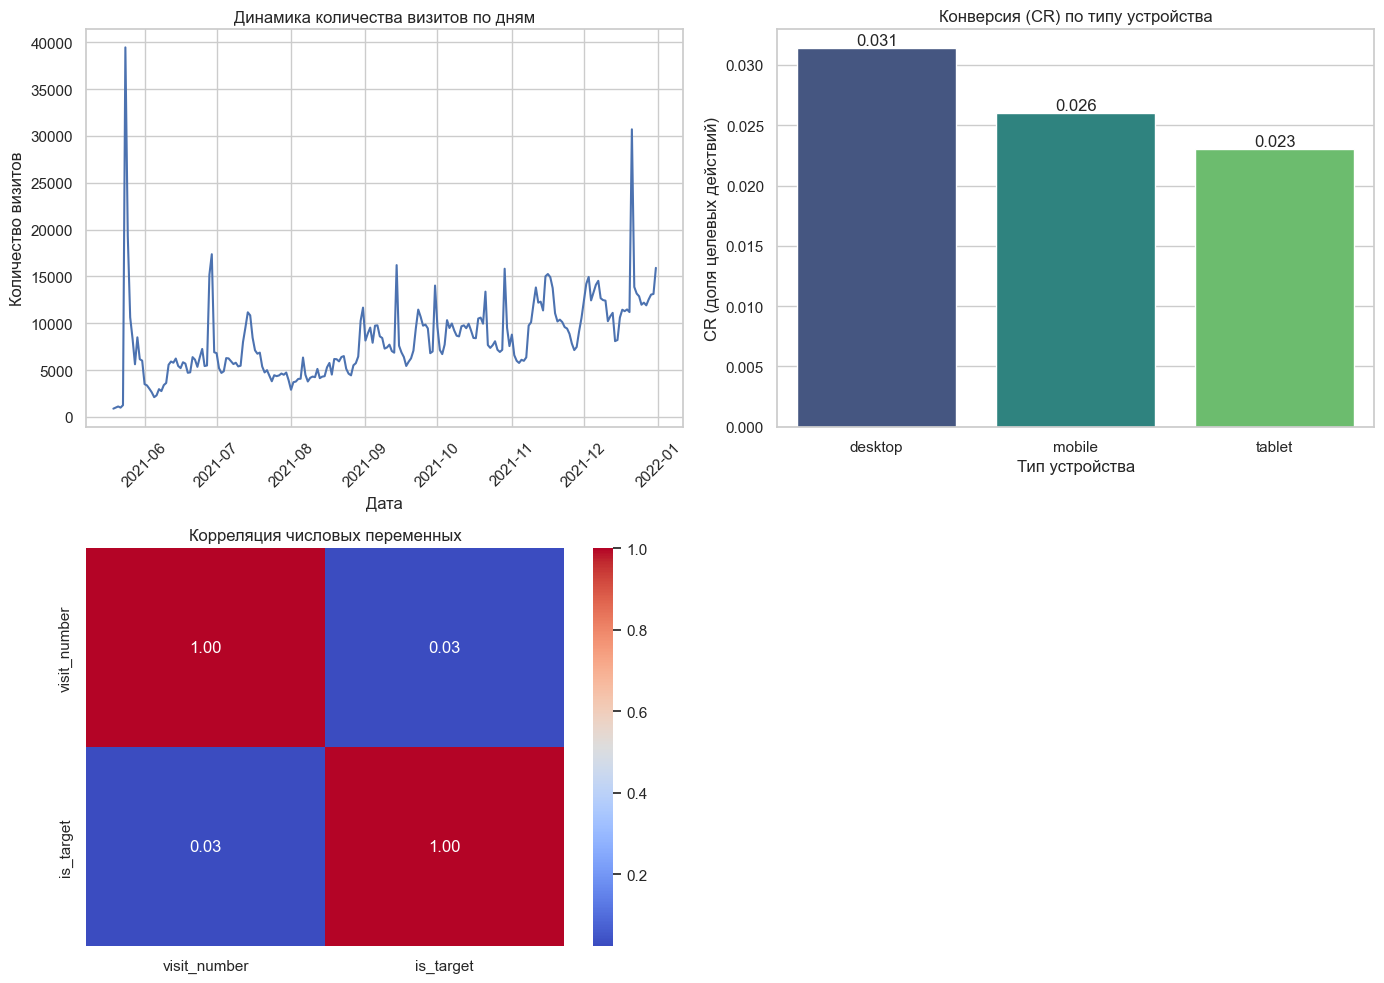

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# --- График 1: Динамика визитов по дням ---
plt.subplot(2, 2, 1)
daily_visits = df_final.groupby('visit_date')['session_id'].count()
plt.plot(daily_visits.index, daily_visits.values, color='#4c72b0')
plt.title('Динамика количества визитов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)

# --- График 2: Конверсия (CR) по типу устройства ---
plt.subplot(2, 2, 2)
device_cr = df_final.groupby('device_category')['is_target'].mean().sort_values(ascending=False)

# ИСПРАВЛЕНИЕ: добавили hue=device_cr.index и legend=False
sns.barplot(x=device_cr.index, y=device_cr.values, hue=device_cr.index, legend=False, palette='viridis')

plt.title('Конверсия (CR) по типу устройства')
plt.ylabel('CR (доля целевых действий)')
plt.xlabel('Тип устройства')

# Добавляем подписи значений
for index, value in enumerate(device_cr.values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

# --- График 3: Тепловая карта корреляций (Heatmap) ---
plt.subplot(2, 2, 3)
# Для корреляции берем только числовые колонки
# В нашем случае это visit_number и целевая переменная is_target
numeric_cols = df_final[['visit_number', 'is_target']]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция числовых переменных')

plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import chi2_contingency

def test_hypothesis(df, group_col, value_a_list, name_a, name_b):
    """
    Функция для проверки гипотезы с помощью Хи-квадрат.
    :param df: Датафрейм
    :param group_col: Колонка, по которой делим (например, device_category)
    :param value_a_list: Список значений, которые относятся к группе А (например, ['mobile'])
    :param name_a: Название группы А для вывода
    :param name_b: Название группы Б для вывода
    """
    # Создаем колонку-флаг для разделения групп
    # Если значение в списке value_a_list, то это Группа А, иначе — Группа Б
    df['group_segment'] = df[group_col].apply(lambda x: name_a if x in value_a_list else name_b)

    # Строим таблицу сопряженности (сколько было 0 и 1 в каждой группе)
    contingency_table = pd.crosstab(df['group_segment'], df['is_target'])

    # Выводим CR для наглядности
    print(f"\n--- Проверка гипотезы: {name_a} vs {name_b} ---")
    print(contingency_table)

    # Считаем Хи-квадрат
    stat, p_value, dof, expected = chi2_contingency(contingency_table)
    alpha = 0.05 # Уровень значимости

    print(f"P-value: {p_value:.5f}")
    if p_value < alpha:
        print(f"✅ РЕЗУЛЬТАТ: Отвергаем нулевую гипотезу. Разница между {name_a} и {name_b} СТАТИСТИЧЕСКИ ЗНАЧИМА.")
    else:
        print(f"❌ РЕЗУЛЬТАТ: Не отвергаем нулевую гипотезу. Статистически значимой разницы нет.")

# ---------------------------------------------------------
# ГИПОТЕЗА 1: Органический трафик vs Платный
# Organic по методичке: utm_medium in ['organic', 'referral', '(none)']
organic_list = ['organic', 'referral', '(none)']
test_hypothesis(df_final, 'utm_medium', organic_list, 'Organic', 'Paid')

# ---------------------------------------------------------
# ГИПОТЕЗА 2: Мобайл vs Десктоп
# Mobile - это 'mobile' и 'tablet' (обычно их объединяют, либо только mobile)
mobile_list = ['mobile', 'tablet']
test_hypothesis(df_final, 'device_category', mobile_list, 'Mobile', 'Desktop')

# ---------------------------------------------------------
# ГИПОТЕЗА 3: Города присутствия vs Регионы
# Города присутствия: Moscow, Saint Petersburg
cities_list = ['Moscow', 'Saint Petersburg']
test_hypothesis(df_final, 'geo_city', cities_list, 'MSK_SPB', 'Regions')


--- Проверка гипотезы: Organic vs Paid ---
is_target            0      1
group_segment                
Organic         494847  20812
Paid           1314881  29502
P-value: 0.00000
✅ РЕЗУЛЬТАТ: Отвергаем нулевую гипотезу. Разница между Organic и Paid СТАТИСТИЧЕСКИ ЗНАЧИМА.

--- Проверка гипотезы: Mobile vs Desktop ---
is_target            0      1
group_segment                
Desktop         355350  11513
Mobile         1454378  38801
P-value: 0.00000
✅ РЕЗУЛЬТАТ: Отвергаем нулевую гипотезу. Разница между Mobile и Desktop СТАТИСТИЧЕСКИ ЗНАЧИМА.

--- Проверка гипотезы: MSK_SPB vs Regions ---
is_target            0      1
group_segment                
MSK_SPB        1071375  30742
Regions         738353  19572
P-value: 0.00000
✅ РЕЗУЛЬТАТ: Отвергаем нулевую гипотезу. Разница между MSK_SPB и Regions СТАТИСТИЧЕСКИ ЗНАЧИМА.


In [11]:
# --- ЧАСТЬ 1: Лучшие источники трафика ---
# Группируем по источнику, считаем кол-во визитов и среднюю конверсию
top_sources = df_final.groupby('utm_source').agg({
    'session_id': 'count',
    'is_target': 'mean'
}).rename(columns={'session_id': 'Visits', 'is_target': 'CR'})

# Сортируем: берем только те, где > 1000 визитов (чтобы убрать шум)
top_sources_filtered = top_sources[top_sources['Visits'] > 1000].sort_values(by='CR', ascending=False)

print("Топ-5 источников по Конверсии (среди крупных):")
print(top_sources_filtered.head(5))


# --- ЧАСТЬ 2: Анализ автомобилей (Самая сложная часть!) ---
# Марка и модель лежат в hits в колонке hit_page_path. Нам нужно их достать.
# Обычно путь выглядит как /sberauto/services/cars/brand/model/...

# Загружаем нужные колонки из hits (если они не в памяти)
# Нам нужны только session_id и hit_page_path
cars_df = df_hits[['session_id', 'hit_page_path']].copy()

# Функция для извлечения модели из URL
# Мы предполагаем, что модель находится в URL. Попробуем простое извлечение.
# Реальные данные могут быть грязными, но для учебного проекта этого хватит.
def extract_car_model(path):
    parts = str(path).split('/')
    # Обычно модель идет после 'cars' или бренда.
    # В этом датасете часто бывает структура /cars/brand/model
    if 'cars' in parts:
        try:
            idx = parts.index('cars')
            # Возвращаем бренд и модель (следующие 2 элемента)
            return f"{parts[idx+1]} {parts[idx+2]}"
        except IndexError:
            return None
    return None

# Применяем функцию (это может занять минуту!)
print("\nИзвлекаем модели авто из URL...")
cars_df['car_model'] = cars_df['hit_page_path'].apply(extract_car_model)

# Убираем пустые значения (где не было машин в URL)
cars_df = cars_df.dropna(subset=['car_model'])

# Соединяем с df_final, чтобы знать, была ли конверсия в этой сессии
cars_stats = cars_df.merge(df_final[['session_id', 'is_target']], on='session_id', how='left')

# Считаем статистику по моделям
top_cars = cars_stats.groupby('car_model').agg({
    'session_id': 'count',
    'is_target': 'mean'
}).rename(columns={'session_id': 'Visits', 'is_target': 'CR'})

print("\nТоп-5 самых популярных авто (по просмотрам):")
print(top_cars.sort_values(by='Visits', ascending=False).head(5))

print("\nТоп-5 авто с лучшей конверсией (среди популярных > 1000 просмотров):")
print(top_cars[top_cars['Visits'] > 1000].sort_values(by='CR', ascending=False).head(5))


# --- ЧАСТЬ 3: Соцсети ---
# Список рекламных меток соцсетей из методички
social_sources = [
    'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxlTijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
    'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
]

# Фильтруем датафрейм: только соцсети
social_df = df_final[df_final['utm_source'].isin(social_sources)]

# Считаем CR соцсетей
social_cr = social_df['is_target'].mean() * 100
total_cr = df_final['is_target'].mean() * 100

print(f"\nКонверсия из Соцсетей: {social_cr:.2f}%")
print(f"Средняя конверсия по сайту: {total_cr:.2f}%")

if social_cr > total_cr:
    print("Вывод: Реклама в соцсетях окупается, конверсия выше средней!")
else:
    print("Вывод: Соцсети работают хуже среднего. Нужно осторожно повышать бюджет.")

Топ-5 источников по Конверсии (среди крупных):
                      Visits        CR
utm_source                            
oZCzWSykfixnjMPDNjSU    3143  0.082724
BKeImrJuRDZcHiSSTdzm    1464  0.066940
aXQzDWsJuGXeBXexNHjc   31152  0.058648
bByPQxmDaMXgpHeypKSM  102287  0.054328
DnEUulZAecfGPvdtZBYS    1420  0.053521

Извлекаем модели авто из URL...

Топ-5 самых популярных авто (по просмотрам):
                   Visits        CR
car_model                          
all skoda          744516  0.094599
all mercedes-benz  472316  0.056607
all volkswagen     417128  0.107505
all lada-vaz       403910  0.103803
all nissan         238701  0.058841

Топ-5 авто с лучшей конверсией (среди популярных > 1000 просмотров):
                Visits        CR
car_model                       
all hyundai      19054  0.129762
all kia         236270  0.108449
all volkswagen  417128  0.107505
all lada-vaz    403910  0.103803
all toyota      160840  0.101543

Конверсия из Соцсетей: 2.01%
Средняя конверсия 